In [1]:
# python -m pip install SoundFile
import glob
import os
from info import i, printb, printr, printp, print
import glob
import os
import librosa
import pdb
import csv
import json
import re
import numpy as np
import random
import librosa.display
import IPython.display as ipd
from sklearn import preprocessing
from collections import Counter
from matplotlib import pyplot as plt
from info import i, printb, printr, printp, print
import muda
import jams
from sklearn import svm
import librosa
import keras

Using TensorFlow backend.


In [10]:
#----------------------------------- parameters to change-----------------------------------#
block_size=1 # blocks of 60 seconds
thresholds=[0, 0.5]  # minimum length for nobee intervals: 0 or 5 seconds (creates one label file per threshold value)
path_audioFiles="C:\\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset"+os.sep  # path to audio files
annotations_path="C:\\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset"+os.sep # path to .lab files
path_save_audio_labels= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_1_second'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
#-------------------------------------------------------------------------------------------#


In [11]:
# if path doesn't exist then create one !!!
if not os.path.exists(path_save_audio_labels):
    os.makedirs(path_save_audio_labels)

In [12]:
def read_beeNotBee_annotations_saves_labels(audiofilename, block_name,  blockStart, blockfinish, annotations_path, threshold=0):
  
    block_length=blockfinish-blockStart
    #print("block_length: ", block_length)
    if audiofilename.startswith('#'):
        annotation_filename=audiofilename[1:-4]+'.lab'
    else :
        annotation_filename=audiofilename[0:-4]+'.lab'
        
        
    try:    
        with open(annotations_path + os.sep + annotation_filename,'r') as f:
            # EXAMPLE FILE:
            
            # CF003 - Active - Day - (223)
            # 0	8.0	bee
            # 8.01	15.05	nobee
            # 15.06	300.0	bee 
            # .
            #
            
            # all files end with a dot followed by an empty line.

            print(annotations_path + os.sep + annotation_filename)
            lines = f.read().split('\n')
        
            labels_th=['bee', 0.0]
            label2assign='bee'
            label_strength=0
            intersected_s=0
                            
            for line in lines:
                if (line == annotation_filename[0:-4]) or (line == '.') or (line ==''):
                    #ignores title, '.', or empty line on the file.
                    continue
                
               ## print("#############################  line ",line)
                parsed_line= line.split('\t')    
                
                assert (len(parsed_line)==3), ('expected 3 fields in each line, got: '+str(len(parsed_line))) 
                
                
                tp0=float(parsed_line[0])
               ## print("tp0: ",tp0)
                tp1=float(parsed_line[1])
               ## print("tp1: ",tp1)
                annotation_label=parsed_line[2]
                if blockfinish < tp0: # no need to read further nobee intervals since annotation line is already after block finishes
                    break
                    
                if annotation_label== 'nobee':
               
                   ## print("...............annotation_label=='nobee'..........................")    
                        
                    if tp1-tp0 >= threshold:  # only progress if nobee interval is longer than defined threshold.
                    
                        if tp0 > blockStart and tp0 <= blockfinish and tp1 >= blockfinish:
                            
                            intersected_s=intersected_s + (blockfinish-tp0)  
                           ## print(" # bs          tp0 ######## bf########tp1")
                            # |____________########|########
                            # bs          tp0      bf      tp1 
                        
                        elif tp1 >= blockStart and tp1 < blockfinish and tp0 <= blockStart:
                            
                            intersected_s=intersected_s+ (tp1-blockStart)
                           ## print("# tp0 ######## bs  ########   tp1    bf")
                            # #####|########_____|
                            # tp0  bs     tp1    bf
                            
                            
                        elif tp1 >= blockStart and tp1 <= blockfinish and tp0 >= blockStart and tp0 <= blockfinish:
                            
                            intersected_s=intersected_s+ (tp1-tp0)
                          ##  print("#bs   tp0  ########  tp1    bf")
                            # |_____########_____|
                            # bs   tp0    tp1    bf
                        
                        elif tp0 <= blockStart and tp1 >= blockfinish:
                            
                            intersected_s=intersected_s + (blockfinish-blockStart)
                          ##  print("tp0 #### bs############bf #### tp1")
                            #  ####|############|####
                            # tp0  bs           bf  tp1
                            
                    if intersected_s > 0:
                        label2assign='nobee'
                    label_strength= intersected_s/block_length # proportion of nobee length in the block
                    
                    
                    labels_th= [label2assign, round(label_strength,3)]  # if label_strehgth ==0 --> bee segment 
                    
                    
            assert (blockfinish <=tp1 ), ('the end of the request block falls outside the file: block ending: '+ str(blockfinish)+' end of file at: '+ str(tp1))
            
                
    except FileNotFoundError as e:
        print(e, '--Anotation file does not exist! label as unknown')
        #print(annotation_filename=audiofilename[0:-4]+'.lab')
            
        label2assign = 'unknown'
        label_strength=-1
        
        labels_th = [label2assign, label_strength]
            
    except Exception as e1:
        print('unknown exception: '+str(e1))
        #quit
    
    
    return labels_th

In [13]:
def load_audioFiles_saves_segments( path_audioFiles,path_save_audio_labels, block_size , thresholds, annotations_path, read_beeNotBee_annotations ='yes', save_audioSegments='yes'):

    
    audiofilenames_list = [os.path.basename(x) for x in glob.glob(path_audioFiles+'*.mp3')]
    audiofilenames_list.extend([os.path.basename(x) for x in glob.glob(path_audioFiles+'*.wav')])
    
    printb("Number of audiofiles in folder: "+str(len(audiofilenames_list)))
   # print("audiofilenames_list ",audiofilenames_list)
    
    fi=0
    for file_name in audiofilenames_list:
        fi=fi+1
       # print('\n')
       # printb('Processing '+ file_name+'          :::file number:  '+str(fi)+' --------->of '+str(len(audiofilenames_list)))
          

        offset=0
        block_id =0
        
        
        while 1:
                    
            # READ ONE BLOCK OF THE AUDIO FILE
            try:
                ## Read one block of 60 seconds 
                block,sr = librosa.core.load(path_audioFiles+file_name, offset=offset, duration=block_size)
               # print(block.shape , sr)
               # print('-----------------Reading segment '+str(block_id))
            except ValueError as e:
                e
                if 'Input signal length' in str(e):
                    block=np.arange(0)
            except FileNotFoundError as e1:
                print(e1, ' but continuing anyway')
                
            ##print("test")
            if block.shape[0] > 0:    #when total length = multiple of blocksize, results that last block is 0-lenght, this if bypasses those cases.
                
                block_name=file_name[0:-4]+'__segment'+str(block_id)
               ## print(block_name)
                
                # READ BEE NOT_BEE ANNOTATIONS:
                if read_beeNotBee_annotations == 'yes':
                   # print('---------------------Will read BeeNotbee anotations and create labels for segment'+str(block_id))
                    blockStart=offset
                    ##print("blockStart: ",blockStart)
                    blockfinish=offset+block_size
                    ##print("blockfinish: ",blockfinish)
                    
                    for th in thresholds:
                        #print("th::::::::::", th)
                        label_file_exists = os.path.isfile(path_save_audio_labels+'labels_BeeNotBee_th'+str(th)+'.csv')
                        with open(path_save_audio_labels+'labels_BeeNotBee_th'+str(th)+'.csv','a', newline='') as label_file:
                            writer =csv.DictWriter(label_file, fieldnames=['sample_name', 'segment_start','segment_finish', 'label_strength', 'label'], delimiter=',')
                            if not label_file_exists:
                                writer.writeheader()
                          ##  print("start read_beeNotBee_annotation_saves_labels")
                            label_block_th=read_beeNotBee_annotations_saves_labels(file_name, block_name,  blockStart, blockfinish, annotations_path, th)                            
                           # print("label_block_th : ", label_block_th)                           
                            writer.writerow({'sample_name': block_name, 'segment_start': blockStart, 'segment_finish': blockfinish , 'label_strength': label_block_th[1],  'label': label_block_th[0]} )
                           # print('-----------------Wrote label for th '+ str(th)+' seconds of segment'+str(block_id)  ) 
                    
               
                # MAKE BLOCK OF THE SAME SIZE:
                if block.shape[0] < block_size*sr:   
                    block = uniform_block_size(block, block_size*sr, 'repeat')
                   # print('-----------------Uniformizing block length of segment'+str(block_id)  ) 

                        
            
                # Save audio segment:
                if save_audioSegments=='yes' and (not os.path.exists(path_save_audio_labels+block_name+'.wav')): #saves only if option is chosen and if block file doesn't already exist.
                    librosa.output.write_wav(path_save_audio_labels+block_name+'.wav', block, sr)
                    #print( '-----------------Saved wav file for segment '+str(block_id))
                
                    
                    
            else :
                #print('----------------- no more segments for this file--------------------------------------')
               # print('\n')
                break
            offset += block_size
            block_id += 1
    printb('______________________________No more audioFiles___________________________________________________')
       
    return 


In [14]:
def uniform_block_size(undersized_block, block_size_samples, method='repeat' ):

    lengthTofill=(block_size_samples)-(undersized_block.size)
    if method == 'zero_padding':
        new_block=np.pad(undersized_block, (0,lengthTofill), 'constant', constant_values=(0) )

    elif method=='mean_padding':
        new_block=np.pad(undersized_block, (0,lengthTofill), 'mean' )
    
    elif method=='repeat':        
        new_block= np.pad(undersized_block, (0,lengthTofill), 'reflect')
    else:
       # print('methods to choose are: \'zero_padding\' ,\'mean_padding\' and \'repeat\' ' )
        new_block=0
              
    return new_block

In [149]:
load_audioFiles_saves_segments( path_audioFiles, path_save_audio_labels, block_size , thresholds, annotations_path, read_beeNotBee_annotations='yes', save_audioSegments='yes')    

In [17]:
# read only labels_BeeNotBee_th0.5
path_beeNotbee_labels = path_save_audio_labels + 'labels_BeeNotBee_th'+str(thresholds[1])+'.csv'
print("path_beeNotbee_labels: ",path_beeNotbee_labels)

[2020-05-02 15:31:18 RAM61.0% 0.08GB] path_beeNotbee_labels:  C:\Users\PC\python\Stage\dataset_BeeNoBee_1_second1sec\labels_BeeNotBee_th0.5.csv


In [18]:
def read_HiveState_fromSampleName( filename, states):   #states: state_labels=['active','missing queen','swarm' ]
    label_state='other'
    for state in states:
        if state in filename.lower():
           # print("1 ", filename)
            label_state = state
    #incorporate condition for Nu-hive recordings which do not follow the same annotation: 'QueenBee' or 'NO_QueenBee'
    
    if label_state=='other':
        if 'NO_QueenBee' in filename:
            ##print("NO_QueenBee",label_state )
            label_state = states[1]
        else:
            label_state=states[0]
    return label_state

In [57]:
def write_Statelabels_from_beeNotBeelabels(path_save, path_labels_BeeNotBee, states=['active','missing queen','swarm' ]):
    
    #label_file_exists = os.path.isfile(path_save+'state_labels.csv')
    liste=[]
    with open(path_labels_BeeNotBee, 'r' ) as rfile, \
    open(path_save+'state_labels.csv', 'w', newline='') as f_out:
        csvreader = csv.reader(rfile, delimiter=',')
        writer= csv.DictWriter(f_out, fieldnames=['sample_name', 'label'], delimiter=',') 
        #if not label_file_exists:
        writer.writeheader()
        
        for row in csvreader:
            if not row[0]=='sample_name':
                if row[4]=='bee':
                    label_state=read_HiveState_fromSampleName(row[0], states)
                    print(row[0],"label_state : ", label_state)
                    writer.writerow({'sample_name':row[0], 'label':label_state})
                else:   liste.append(row[0])  
    return liste

In [150]:
 # reads labels beeNotBee files and creates corresponding states label file
liste= write_Statelabels_from_beeNotBeelabels(path_save_audio_labels, path_beeNotbee_labels, states=['active','missing queen','swarm' ])
    

In [70]:
import os
for i in range(len(liste)):
    os.remove(path_save_audio_labels+liste[i]+'.wav')
#liste[0]  

In [71]:
def get_list_samples_names(path_audioSegments_folder, extension='.wav'):
    # Recupèrer tout les audios d'extention .wav"""""" glob.glob(path_audioSegments_folder+'*'+extension)""""""
    sample_ids=[os.path.basename(x) for x in glob.glob(path_audioSegments_folder+'*'+extension)]
    return sample_ids
    

In [72]:
sample_ids=get_list_samples_names(path_save_audio_labels) # get sample ids from audio segments folder.
print(len(sample_ids) ) 
sample_ids[0:10]

[2020-05-02 16:32:14 RAM67.5% 0.19GB] 17295


['CF001 - Missing Queen - Day -__segment0.wav',
 'CF001 - Missing Queen - Day -__segment1.wav',
 'CF001 - Missing Queen - Day -__segment10.wav',
 'CF001 - Missing Queen - Day -__segment11.wav',
 'CF001 - Missing Queen - Day -__segment12.wav',
 'CF001 - Missing Queen - Day -__segment13.wav',
 'CF001 - Missing Queen - Day -__segment14.wav',
 'CF001 - Missing Queen - Day -__segment15.wav',
 'CF001 - Missing Queen - Day -__segment2.wav',
 'CF001 - Missing Queen - Day -__segment3.wav']

In [153]:
#----------------------------------- parameters to change-----------------------------------#
block_size=1 # blocks of 60 seconds
path_workingFolder='C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_1_second'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
labels2read= 'state_labels'
feature = 'MFCCs20'
#-----------------------------------parameters for TTBOX -----------------------------------#
import timbre_descriptor as td
import numpy as np
import scipy as sc
import my_tools as mt
from collections import namedtuple
import scipy
import scipy.signal
from scipy.io import wavfile

import matplotlib
import swipep as swp             # used for sing le-F0 estimation
import warnings                 # used for warning removal
import time               # used performance benchmark
import librosa
nbits = 16;
MAX_VAL = pow(2,(nbits-1)) * 1.0;

In [161]:
    
def raw_feature_fromSample( path_audio_sample, feature2extract ):
        
    s, Fs = librosa.core.load(path_audio_sample) # sr= 22050
    #m = re.match(r"\w+s(\d+)", feature2extract) #  m:  <re.Match object; span=(0, 7), match='MFCCs20'>
    #n_freqs=int(m.groups()[0]) ## n_freqs= 20
    #Melspec = librosa.feature.melspectrogram(audio_sample, n_mels = n_freqs) # computes mel spectrograms from audio sample, 
    
    if 'MFCCs' in feature2extract:
        n_freqs = int(feature2extract[5:len(feature2extract)]) ## n_freqs==20
       # Melspec = librosa.feature.melspectrogram(audio_sample, sr=sr)
       # x = librosa.feature.mfcc(S=librosa.power_to_db(Melspec),sr=sr, n_mfcc = n_freqs)
        x = librosa.feature.mfcc(s ,Fs=Fs, n_mfcc = n_freqs)
        #print(x.shape)
    elif 'TTBOX' in feature2extract:
        r_Fs = librosa.resample(s, Fs, 44100)
        r_Fs=44100
        s= s/MAX_VAL;
        N = len(s);
       
        desc_TEE, desc_AS, desc_STFTmag, desc_STFTpow, desc_Har, desc_ERB, desc_GAM =td.compute_all_descriptor(s, r_Fs);
        desc  = [desc_TEE, desc_AS, desc_STFTmag, desc_STFTpow, desc_Har, desc_ERB, desc_GAM];

        ### Time serie integration
        param_val, field_name = td.temporalmodeling(desc);
        x=param_val
    else:
        x = Melspec

    return x 

In [162]:
def get_features_from_samples(path_audio_samples, sample_ids, raw_feature, normalization, high_level_features ): 
    #normalization = NO, z_norm, min_max
    ## function to extract features 
    #high_level_features = 0 or 1 
    
    n_samples_set = len(sample_ids) # 4
    feature_Maps = []
    
    for sample in sample_ids:
        # raw feature extraction:
       # print("sample: ",sample)
        x = raw_feature_fromSample( path_audio_samples+sample, raw_feature ) # x.shape: (4, 20, 2584)
       # print("x.shape: ",x.shape)
        
        ##normalization here:si on veut les résultats pour Conv1D on utlise la normalisation 
        ##normalization here:
        if not normalization == 'NO':
             x_norm = featureMap_normalization_block_level(x, normalizationType = normalization) 
        else: x_norm = x
        
        if high_level_features:
            # high level feature extraction:
            if 'MFCCs' in raw_feature:
                X = compute_statistics_overMFCCs(x_norm, 'yes') # X.shape: (4 , 120)
            else: 
                X = compute_statistics_overSpectogram(x_norm)
                
            feature_map=X
        else:
            feature_map=x_norm
        
        
        feature_Maps.append(feature_map)
        
    return feature_Maps

In [85]:
X=get_features_from_samples(path_workingFolder, sample_ids, 'MFCCs20', 'NO', 0)

In [86]:
def labels2binary(pos_label, list_labels):  # pos_label = missing queen / nobee
    list_binary_labels=[]
    for l in list_labels:
        #print("l=", l, "pos_label= ", pos_label)
        if l == pos_label:
            list_binary_labels.append(1)
        else:
            list_binary_labels.append(0)
    return list_binary_labels

In [87]:
def get_GT_labels_fromFiles(path_labels, sample_ids, labels2read) : #labels2read =  name of the label file    
    
    ##reads labels files and retreives labels for a sample set given by sample_ids
    # input:  path_labels: where label file is 
    #         sample_ids: list of sample names that we want the label
    #         labels2read: name of the labels file: state_labels, labels_BeeNotBee_th0 ...
    
    # output: list of string labels, in same order as sample_ids list
    
    labels = []
    fileAsdict={}
    
    with open(path_labels + labels2read+'.csv', 'r') as labfile:
        csvreader = csv.reader(labfile, delimiter=',')    
        for row in csvreader:
            if not row[0] == 'sample_name':
               # print("row[0]",row[0]) # CF001 - Missing Queen - Day -__segment0
               # print("row[-1]:", row[-1])  # bee or nobee
                fileAsdict[row[0]]=row[-1]   # row[-1] = '/missing queen/active' or 'bee/nobee'
            
    for sample in sample_ids:
        #print(sample)
        #print(fileAsdict[sample[0:-4]]) # bee nobee or unknown 
        labels.append(fileAsdict[sample[0:-4]])  #remove .wav extension
    
       
    return labels  


In [89]:
labels = get_GT_labels_fromFiles(path_workingFolder, sample_ids, labels2read)
Y= labels2binary('active', labels)
labels[0:10], Y[0:10]

(['missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen',
  'missing queen'],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [90]:
def get_items2replicate(list_Binary_labels, list_sample_ids):
    
    # get the samples to be replicated.
    # input: list of labels and sample_ids with same oreder!
    # ouptut: dictionary keys:name of samples to be replicated,  value: Number of times to replicate that sample.
    
    #assert( len(list_Binary_labels) - len(list_sample_ids) == 0), ('arguments should have the same number of elements)
    dict_items_replicate={}
    
    n_samples = len(list_Binary_labels)# 193
    #print("n_samples: ", list_Binary_labels)
    n_positive_labels = sum(list_Binary_labels)#158 = le nbr de 1
    #print("n_positive_labels: ",n_positive_labels)
    n_negative_labels = n_samples - n_positive_labels #35= le nbr de 0
    #print("n_negative_labels: ",n_negative_labels)
    
    pos_samples=[]
    neg_samples=[]
    
    for i in range(n_samples):
        if list_Binary_labels[i] == 1 :
            #print("list_sample_ids[i]= : ", list_sample_ids[i])
            pos_samples.append(list_sample_ids[i])
        else: 
            neg_samples.append(list_sample_ids[i])
            
    if n_positive_labels > n_negative_labels:
        #print(n_positive_labels, n_negative_labels)
        # Replicate negative samples as needed:
        dif=n_positive_labels-n_negative_labels
        items_replicate=random.choices(neg_samples, k=dif)
       # print("neg_samples= ",neg_samples, "items_replicate=",items_replicate)
 
    elif n_positive_labels < n_negative_labels:
        dif=n_negative_labels-n_positive_labels
        items_replicate=random.choices(pos_samples, k=dif)
              
    dict_items_replicate=Counter(items_replicate)
    #print(dict_items_replicate)
    return dict_items_replicate


In [91]:
def BalanceData_online(y_set, x_set, sample_ids_set):
    
    ## balances already processed data (X and Y, just before classifier) by replicating samples of the least represented class.
    # input: y_set - binary labels of set, x_set - feature_maps of set, sample_ids_set - sample names in set, ( all have the same order!)
    # output: X, Y and sample_ids with replicated samples concatenated 
    
 
    printb( 'Balancing training data:' )
    print('will randomly replicate samples from least represented class')
    
    x2concatenate = x_set
    y2concatenate = y_set
    sample_ids2concatenate = sample_ids_set
    
    dict_items_replicate = get_items2replicate(y_set,sample_ids_set )
    #print("dict_items_replicate: ",dict_items_replicate)
    
    for i in range(len(sample_ids_set)):
        if sample_ids_set[i] in dict_items_replicate.keys() :
            
            sample_ids2concatenate =np.concatenate([sample_ids2concatenate, [sample_ids_set[i]]*dict_items_replicate[sample_ids_set[i]]])
            y2concatenate = np.concatenate([y2concatenate, [y_set[i]]*dict_items_replicate[sample_ids_set[i]]])
            x2concatenate = np.concatenate([x2concatenate, [x_set[i]]*dict_items_replicate[sample_ids_set[i]]])
            
    return y2concatenate, x2concatenate, sample_ids2concatenate

In [92]:
y_concat, x_concat, sample_ids_concat= BalanceData_online(Y, X, sample_ids)

[2020-05-02 17:48:39 RAM74.4% 0.82GB] Balancing training data:
[2020-05-02 17:48:39 RAM74.4% 0.82GB] will randomly replicate samples from least represented class


In [110]:
x, y, z= x_concat.shape
X=x_concat.reshape(x, y*z)
Y=y_concat
Y.shape,X.shape

((17702,), (17702, 880))

In [112]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((15931, 880), (1771, 880), (15931,), (1771,))

In [115]:
def SVM_Classification_BeehiveSTATE(X_flat_train, y_train, X_flat_test, y_test, kerneloption='rbf'):

    print('\n')
    printb('Starting classification with SVM:')
    Test_Preds=[]
    Train_Preds=[]
    Test_Preds_Proba=[]
    Train_Preds_Proba=[]
    Test_GroundT=[]
    Train_GroundT=[]
   
    print('\n')
    printb('classification Beehive State into : Active or Missing Queen')
        
    #train :
    CLF = svm.SVC(kernel=kerneloption, probability=True)
    CLF.fit(X_flat_train, y_train)
    y_pred_train = CLF.predict(X_flat_train)
    y_pred_proba_train = CLF.predict_proba(X_flat_train)
    
    Train_GroundT = y_train
    Train_Preds = y_pred_train
    Train_Preds_Proba = y_pred_proba_train[:,1]
    
    # test:
    y_pred_test = CLF.predict(X_flat_test)
    y_pred_proba_test = CLF.predict_proba(X_flat_test)
    Test_GroundT= y_test
    Test_Preds = y_pred_test
    Test_Preds_Proba = y_pred_proba_test[:,1]

    return CLF, Test_GroundT, Train_GroundT, Test_Preds, Train_Preds, Test_Preds_Proba, Train_Preds_Proba 

In [116]:
CLF, Test_GroundT, Train_GroundT, Test_Preds, Train_Preds, Test_Preds_Proba, Train_Preds_Proba = SVM_Classification_BeehiveSTATE(x_train, y_train , x_test, y_test, kerneloption='rbf')

[2020-05-02 17:57:12 RAM68.1% 0.49GB] 

[2020-05-02 17:57:12 RAM68.1% 0.49GB] Starting classification with SVM:
[2020-05-02 17:57:12 RAM68.1% 0.49GB] 

[2020-05-02 17:57:12 RAM68.1% 0.49GB] classification Beehive State into : Active or Missing Queen


In [117]:
Test_GroundT.shape, Train_GroundT.shape, Test_Preds.shape, Train_Preds.shape, Test_Preds_Proba.shape, Train_Preds_Proba.shape

((1771,), (15931,), (1771,), (15931,), (1771,), (15931,))

In [118]:
from sklearn import metrics
print("Accuracy: ", metrics.accuracy_score( Test_GroundT, Test_Preds))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(Test_GroundT, Test_Preds))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(Test_GroundT, Test_Preds))

[2020-05-02 18:32:01 RAM66.1% 0.55GB] Accuracy:  0.9023150762281197
[2020-05-02 18:32:01 RAM66.1% 0.55GB] Precision: 0.9093959731543624
[2020-05-02 18:32:02 RAM66.1% 0.55GB] Recall: 0.8983425414364641


In [119]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names= ['missing queen', 'active' ]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



[2020-05-02 18:32:17 RAM66.9% 0.55GB] Confusion matrix, without normalization
[2020-05-02 18:32:17 RAM66.9% 0.55GB] [[785  81]
 [ 92 813]]
[2020-05-02 18:32:17 RAM66.9% 0.55GB] Normalized confusion matrix
[2020-05-02 18:32:17 RAM66.9% 0.55GB] [[0.91 0.09]
 [0.1  0.9 ]]


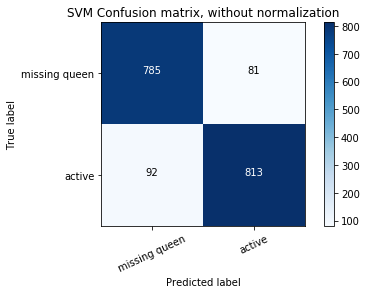

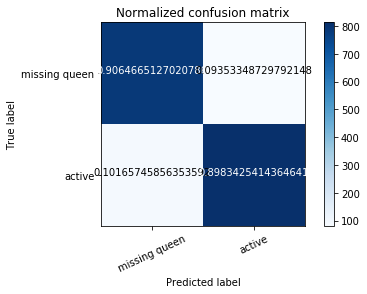

[2020-05-02 18:32:18 RAM67.0% 0.55GB] 
Clasification report SVM:
                precision    recall  f1-score   support

missing_queen       0.90      0.91      0.90       866
       active       0.91      0.90      0.90       905

     accuracy                           0.90      1771
    macro avg       0.90      0.90      0.90      1771
 weighted avg       0.90      0.90      0.90      1771



In [120]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Test_GroundT, Test_Preds )
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='SVM Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
target_names=['missing_queen', 'active']
print ('\nClasification report SVM:\n', classification_report(Test_GroundT, Test_Preds , target_names=target_names))

# CNN Classification 

In [121]:
X= X.reshape(-1, 20, 44, 1)
Y=Y.reshape(-1, 1)
X.shape, Y.shape

((17702, 20, 44, 1), (17702, 1))

In [122]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays

X = np.array(X.tolist())
y = np.array(Y.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.1, random_state = 42)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [123]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15931, 20, 44, 1), (1771, 20, 44, 1), (15931, 2), (1771, 2))

In [127]:
import keras 
from keras.models import Sequential, Input, Model 
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D , MaxPooling2D
from keras.layers.normalization import BatchNormalization 
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop



# Neural Network Architecture 
model=Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=( 20,44, 1), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
# we add the dropout to skip the overfitting 
# model.add(Dropout(0.25))



model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))

# we add the dropout to skip the overfitting 
# model.add(Dropout(0.25))

model.add(Conv2D(16, kernel_size=(3,1), activation='relu', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
#model.add(Dropout(0.25))

model.add(Conv2D(16, kernel_size=(3,1), activation='relu', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))

# we add the dropout to skip the overfitting 
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))

model.add(Dense(32 , activation='relu'))
model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [128]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [129]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 20, 44, 16)        160       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 20, 44, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 22, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 22, 16)        2320      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 10, 22, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 11, 16)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 11, 16)        

In [130]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1] 

1771/1771 [==============================] - ETA: 19 - ETA: 3 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 587us/step


In [131]:
print("Pre-training accuracy: %.4f%%" % accuracy)

[2020-05-02 18:35:34 RAM63.3% 0.68GB] Pre-training accuracy: 51.1011%


In [151]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from keras.callbacks import EarlyStopping

num_epochs = 50
num_batch_size = 145

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                              # verbose=1, save_best_only=True)
start = datetime.now()

adam= model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

[2020-05-04 10:44:38 RAM64.9% 0.47GB] Training completed in time:  0:00:00


In [141]:
# Evaluating the model on the training and testing set
score1 = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score1[1])
# save the model 
#model.save("model_benotos.h5py")

15931/15931 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 336us/step
[2020-05-02 18:51:22 RAM62.0% 0.7GB] Training Accuracy:  0.9984307289123535


In [142]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

1771/1771 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 342us/step
[2020-05-02 18:51:25 RAM61.9% 0.7GB] Testing Accuracy:  0.9954828023910522


In [143]:
print("Testing Accuracy: ", score[1])

[2020-05-02 18:51:28 RAM62.0% 0.7GB] Testing Accuracy:  0.9954828023910522


[2020-05-02 18:51:31 RAM62.0% 0.7GB] dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


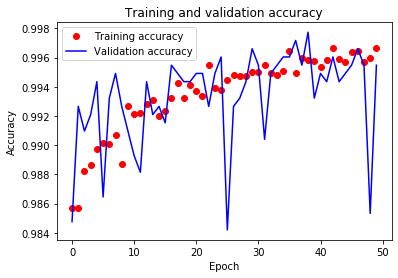

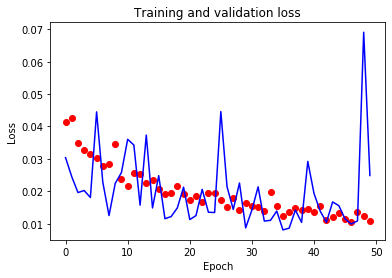

In [144]:
# Visualise and list all data in history
# ---------------------------------------------------    
print(adam.history.keys())

accuracy= adam.history['accuracy']
val_accuracy=adam.history['val_accuracy']
loss=adam.history['loss']

val_loss=adam.history['val_loss']

epochs=range(len(accuracy))
fig = plt.figure()
plt.plot(epochs, accuracy,'ro',  label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
fig.savefig('accuracy.png')
plt.legend()
fig = plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
fig.savefig('loss.png')
#plt.legend()
plt.show()

In [145]:
# Predict labels: 
predicted_classes= model.predict(x_test)

predicted_classes=np.argmax(np.round(predicted_classes), axis=1)

In [146]:
rounded_predictions = model.predict_classes(x_test, batch_size=128, verbose=0)
rounded_predictions[1]

1

In [147]:
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

1

[2020-05-02 18:52:15 RAM62.9% 0.7GB] Confusion matrix, without normalization
[2020-05-02 18:52:15 RAM62.9% 0.7GB] [[865   1]
 [  7 898]]
[2020-05-02 18:52:15 RAM62.9% 0.7GB] Normalized confusion matrix
[2020-05-02 18:52:15 RAM62.9% 0.7GB] [[1.   0.  ]
 [0.01 0.99]]


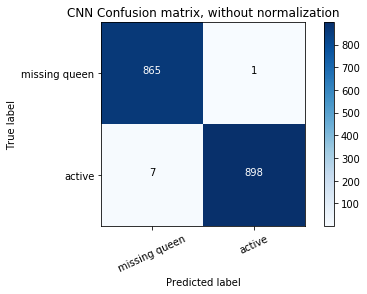

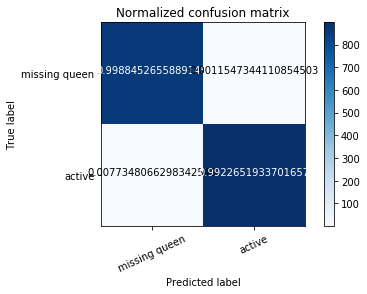

[2020-05-02 18:52:16 RAM62.9% 0.7GB] 
Clasification report CNN:
                precision    recall  f1-score   support

missing_queen       0.99      1.00      1.00       866
       active       1.00      0.99      1.00       905

     accuracy                           1.00      1771
    macro avg       1.00      1.00      1.00      1771
 weighted avg       1.00      1.00      1.00      1771



In [148]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(rounded_labels, rounded_predictions)
#cm
fig = plt.figure()
# Compute confusion matrix
cnf_matrix = confusion_matrix(rounded_labels, rounded_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='CNN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
target_names=['missing_queen', 'active']
print ('\nClasification report CNN:\n', classification_report(rounded_labels, rounded_predictions, target_names=target_names ))

# Method 3: TTBOX:

In [ ]:
from keras.models import Sequantial 
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization, Activation

In [ ]:
X=get_features_from_samples(path_workingFolder, sample_ids, 'TTBOX', 'NO', 0)

In [ ]:
labels = get_GT_labels_fromFiles(path_workingFolder, sample_ids, labels2read)
Y= labels2binary('active', labels)
labels[0:10], Y[0:10]

In [ ]:
#y_concat_ttbox, x_concat_ttbox, sample_ids_concat_ttbox= BalanceData_online(Y, X, sample_ids)
X.shape, Y.shape

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

In [ ]:
# Create the model
model=sequential()
# the first Dense layer
model.add(Dense(50, input_shape=(164, )))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# the second dense layer 
model.add(Dense(10))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# the output layer 
model.add(Dense(2), activation="softmax")

model.compile (loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()


In [ ]:
model.fit(x_train, y_train, batch_size=100, epochs=100)

In [ ]:
# Evaluating the model on the training and testing set
score1 = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score1[1])

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

In [ ]:
from sklearn.metrics import roc_auc_score
print("Auc pour TTBOX:", roc_auc_score(y_test, model.predict_prob(x_test, verbose=0).reshape(-1),))


In [ ]:
Test_Preds=model.predict_prob(x_test, verbose=0).reshape(-1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, Test_Preds )
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='SVM Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

target_names=['missing_queen', 'active']
print ('\nClasification report SVM:\n', classification_report(y_test, Test_Preds , target_names=target_names))